In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler

# Loading + Preprocessing Data

In [2]:
#dataset_dir = "/Users/annie/Documents/DATA_207/finalproj/CIFAKE/"
#Thank you for running this :) 
dataset_dir = os.path.join(os.getcwd(), "CIFAKE")

img_height = 32
img_width = 32
batch_size = 500

# Load the training data
train_ds = tf.keras.utils.image_dataset_from_directory(
  os.path.join(dataset_dir, "train"),
  validation_split=0.2,
  subset="training",
  seed = 512,
  image_size = (img_height, img_width),
  batch_size = 80000)
train_ds

Found 100000 files belonging to 2 classes.
Using 80000 files for training.


<BatchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [3]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  os.path.join(dataset_dir, "train"),
  validation_split=0.2,
  subset="validation",
  seed = 512,
  image_size = (img_height, img_width),
  batch_size = 20000)
val_ds

Found 100000 files belonging to 2 classes.
Using 20000 files for validation.


<BatchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [4]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  os.path.join(dataset_dir, "test"),
  seed = 512,
  image_size = (img_height, img_width), 
  batch_size = 20000)
test_ds

Found 20000 files belonging to 2 classes.


<BatchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [5]:
train_list = list(train_ds)

In [6]:
train_imgs = train_list[0][0].numpy()
train_labels = train_list[0][1].numpy()

In [7]:
norm_train_imgs = train_imgs/255.0
norm_train_imgs.shape

(80000, 32, 32, 3)

In [8]:
classes = train_ds.class_names

In [9]:
val_list = list(val_ds)
val_imgs = val_list[0][0].numpy()
val_labels = val_list[0][1].numpy()

In [10]:
norm_val_imgs = val_imgs/255.0
norm_val_imgs.shape

(20000, 32, 32, 3)

In [11]:
nsamples, nx, ny, nrgb = norm_train_imgs.shape
norm_train_imgs2 = norm_train_imgs.reshape((nsamples,nx*ny*nrgb))
norm_train_imgs2.shape

(80000, 3072)

In [12]:
nsamplesv, nxv, nyv, nrgbv = norm_val_imgs.shape
norm_val_imgs2 = norm_val_imgs.reshape((nsamplesv,nxv*nyv*nrgbv))
norm_val_imgs2.shape

(20000, 3072)

In [13]:
test_list = list(test_ds)
test_imgs = test_list[0][0].numpy()
test_labels = test_list[0][1].numpy()

In [14]:
norm_test_imgs = test_imgs/255.0
testsamples, testx, testy, testrgb = norm_test_imgs.shape
norm_test_imgs2 = norm_test_imgs.reshape((testsamples,testx*testy*testrgb))
norm_test_imgs2.shape

(20000, 3072)

# PCA

In [15]:
scaler = StandardScaler()
train_x = scaler.fit_transform(norm_train_imgs2)
val_x = scaler.fit_transform(norm_val_imgs2)
test_x = scaler.fit_transform(norm_test_imgs2)

In [16]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(train_x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principalcomponent1',
                                                                  'principalcomponent2'])
label = pd.DataFrame(data = train_labels)
principalDf = pd.concat([principalDf,label],axis = 1,ignore_index=True)

principalDf.columns = ["principalcomponent1", "principalcomponent2", "label"] 

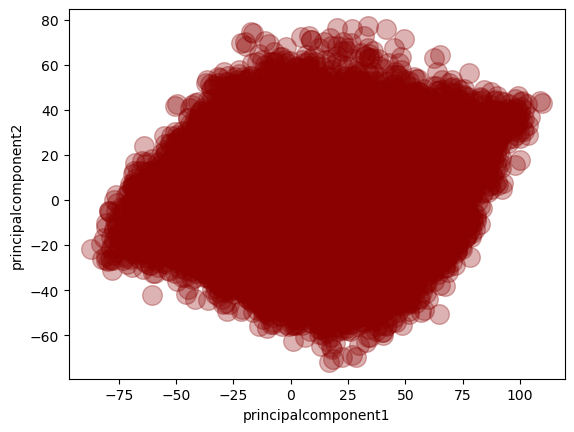

In [17]:
sns.regplot(x=principalDf["principalcomponent1"], y=principalDf["principalcomponent2"],
            fit_reg=False, scatter_kws={"color":"darkred","alpha":0.3,"s":200} );

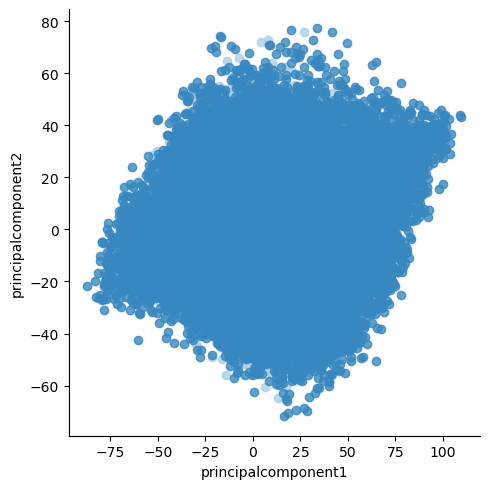

<Figure size 1300x1000 with 0 Axes>

In [18]:
sns.lmplot( x='principalcomponent1', y='principalcomponent2', data=principalDf, fit_reg=False, 
           hue='label', legend=False, palette="Blues")
plt.figure(figsize=(13,10));

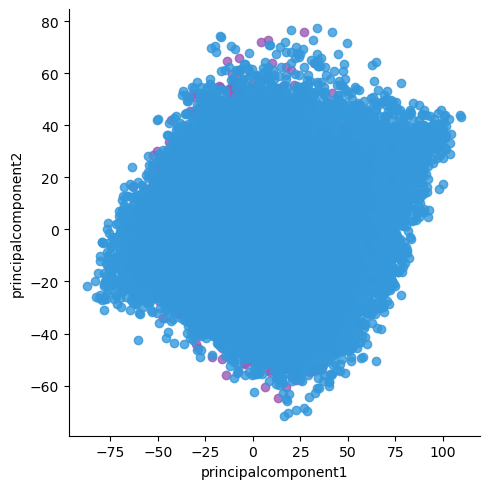

<Figure size 1300x1000 with 0 Axes>

In [19]:
flatui = ["#9b59b6", "#3498db", "orange"]
sns.set_palette(flatui)
sns.lmplot( x="principalcomponent1", y="principalcomponent2", data=principalDf, fit_reg=False,
           hue='label', legend=False)

plt.figure(figsize=(13,10));

In [20]:
principalDf

,principalcomponent1,principalcomponent2,label
0,43.702690,-23.974407,1
1,-6.674533,-15.839950,1
2,9.248898,-41.261497,0
3,7.084215,-17.515516,1
4,-6.000761,-19.375643,1
...,...,...,...
79995,2.364964,18.841240,1
79996,7.918013,-1.422468,1
79997,73.993637,17.517546,1
79998,-31.590235,-18.923016,1


In [21]:
pca2 = PCA(.95)

pca2.fit(train_x)

train_2 = pca.transform(train_x)
val_2 = pca.transform(val_x)
test_2 = pca.transform(test_x)

In [22]:
train_2.shape

(80000, 2)

In [23]:
val_2.shape

(20000, 2)

# SVM Model Creation + Training + Validation Accuracy

# GRID SEARCH

In [ ]:
#support vector machine implementation
param_grid={'C':[0.1,1,10,100],
            'gamma':[0.0001,0.001,0.1,1],
            'kernel':['rbf','poly']}

svc=svm.SVC(probability=True)

model=GridSearchCV(svc,param_grid, verbose = 5)

In [ ]:
model.fit(train_2, train_labels)

In [2]:
# Testing the model using the validation data
y_pred_val = model.predict(val_2)

# Calculating the accuracy of the model on validation data
accuracy = accuracy_score(y_pred_val, val_labels)

# Print the accuracy of the model on the validation data
print(f"The model is {accuracy*100}% accurate")

NameError: name 'Classifier' is not defined

# Hyperparameter tuning manually

### poly kernel for SVM

In [25]:
Classifier = svm.SVC(kernel='poly')


In [26]:
Classifier.fit(train_2, train_labels)

SVC(kernel='poly')

In [27]:
# Testing the model using the validation data
y_pred_val = Classifier.predict(val_2)

# Calculating the accuracy of the model on validation data
accuracy = accuracy_score(y_pred_val, val_labels)

# Print the accuracy of the model on the validation data
print(f"The model is {accuracy*100}% accurate")

The model is 57.475% accurate


### rbf for SVM

In [28]:
Classifier = svm.SVC(kernel='rbf')

In [29]:
Classifier.fit(train_2, train_labels)

SVC()

In [30]:
# Testing the model using the validation data
y_pred_val = Classifier.predict(val_2)

# Calculating the accuracy of the model on validation data
accuracy = accuracy_score(y_pred_val, val_labels)

# Print the accuracy of the model on the validation data
print(f"The model is {accuracy*100}% accurate")

The model is 59.904999999999994% accurate


### rbf for SVM with C = 0.1

In [33]:
Classifier = svm.SVC(C=0.1, kernel='rbf')
Classifier.fit(train_2, train_labels)

SVC(C=0.1)

In [34]:
# Testing the model using the validation data
y_pred_val = Classifier.predict(val_2)

# Calculating the accuracy of the model on validation data
accuracy = accuracy_score(y_pred_val, val_labels)

# Print the accuracy of the model on the validation data
print(f"The model is {accuracy*100}% accurate")

The model is 59.925% accurate


### rbf for SVM with C = 10

In [35]:
Classifier = svm.SVC(C=10, kernel='rbf')
Classifier.fit(train_2, train_labels)

SVC(C=10)

In [36]:
# Testing the model using the validation data
y_pred_val = Classifier.predict(val_2)

# Calculating the accuracy of the model on validation data
accuracy = accuracy_score(y_pred_val, val_labels)

# Print the accuracy of the model on the validation data
print(f"The model is {accuracy*100}% accurate")

The model is 60.02499999999999% accurate


### rbf for SVM with C = 100

In [37]:
Classifier = svm.SVC(C=100, kernel='rbf')
Classifier.fit(train_2, train_labels)

SVC(C=100)

In [38]:
# Testing the model using the validation data
y_pred_val = Classifier.predict(val_2)

# Calculating the accuracy of the model on validation data
accuracy = accuracy_score(y_pred_val, val_labels)

# Print the accuracy of the model on the validation data
print(f"The model is {accuracy*100}% accurate")

The model is 59.975% accurate


### rbf for SVM with gamma = 0.1

In [28]:
Classifier = svm.SVC(C=100, kernel='rbf', gamma = 0.1)
Classifier.fit(train_2, train_labels)

SVC(C=100, gamma=0.1)

In [29]:
# Testing the model using the validation data
y_pred_val = Classifier.predict(val_2)

# Calculating the accuracy of the model on validation data
accuracy = accuracy_score(y_pred_val, val_labels)

# Print the accuracy of the model on the validation data
print(f"The model is {accuracy*100}% accurate")

The model is 59.8% accurate


### rbf for SVM with gamma = 0.0001

In [30]:
Classifier = svm.SVC(C=100, kernel='rbf', gamma = 0.0001)
Classifier.fit(train_2, train_labels)

SVC(C=100, gamma=0.0001)

In [31]:
# Testing the model using the validation data
y_pred_val = Classifier.predict(val_2)

# Calculating the accuracy of the model on validation data
accuracy = accuracy_score(y_pred_val, val_labels)

# Print the accuracy of the model on the validation data
print(f"The model is {accuracy*100}% accurate")

The model is 59.83500000000001% accurate


### rbf for SVM with gamma = 0.001

In [32]:
Classifier = svm.SVC(C=100, kernel='rbf', gamma = 0.001)
Classifier.fit(train_2, train_labels)

SVC(C=100, gamma=0.001)

In [33]:
# Testing the model using the validation data
y_pred_val = Classifier.predict(val_2)

# Calculating the accuracy of the model on validation data
accuracy = accuracy_score(y_pred_val, val_labels)

# Print the accuracy of the model on the validation data
print(f"The model is {accuracy*100}% accurate")

The model is 59.985% accurate


### final model

In [24]:
final_classifier = svm.SVC(C=10, kernel='rbf', gamma=0.01)

In [25]:
final_classifier.fit(train_2, train_labels)

SVC(C=10, gamma=0.01)

In [26]:
# Testing the model using the training data
y_pred_train = final_classifier.predict(train_2)

# Calculating the accuracy of the model on training data
accuracy = accuracy_score(y_pred_train, train_labels)

# Print the accuracy of the model on the training data
print(f"The model is {accuracy*100}% accurate")

The model is 60.0225% accurate


In [26]:
# Testing the model using the validation data
y_pred_val = final_classifier.predict(val_2)

# Calculating the accuracy of the model on validation data
accuracy = accuracy_score(y_pred_val, val_labels)

# Print the accuracy of the model on the validation data
print(f"The model is {accuracy*100}% accurate")

The model is 60.309999999999995% accurate


In [27]:
print(classification_report(val_labels, y_pred_val))

              precision    recall  f1-score   support

           0       0.59      0.68      0.63      9985
           1       0.62      0.53      0.57     10015

    accuracy                           0.60     20000
   macro avg       0.61      0.60      0.60     20000
weighted avg       0.61      0.60      0.60     20000



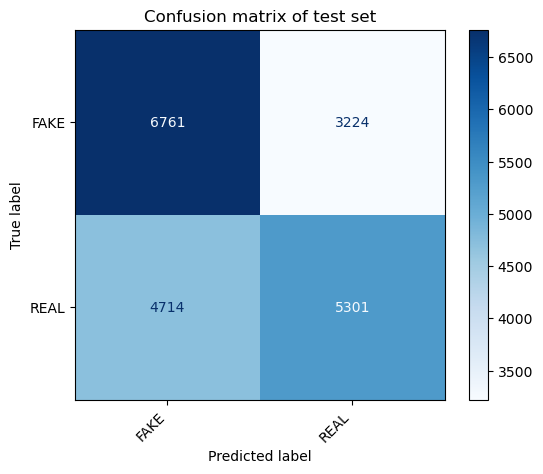

In [28]:
ConfusionMatrixDisplay.from_predictions(val_labels, y_pred_val, display_labels=classes, cmap='Blues')

plt.title('Confusion matrix of test set')
plt.xticks(rotation=45, ha='right')
plt.show()

# Model Results on Test Set

## Note to jasmine - if gridsearch converges uncomment the line below

In [29]:
# uncomment this line below and comment one below that if gridsearch converges
#y_test_pred = model.predict(test_2)
y_test_pred = final_classifier.predict(test_2)

# Calculating the accuracy of the model on the test set
accuracy = accuracy_score(y_test_pred, test_labels)

# Print the accuracy of the model on the test set
print(f"The model is {accuracy*100}% accurate")

The model is 60.415% accurate


In [30]:
print(classification_report(y_test_pred, test_labels))

              precision    recall  f1-score   support

           0       0.68      0.59      0.63     11555
           1       0.53      0.62      0.57      8445

    accuracy                           0.60     20000
   macro avg       0.60      0.61      0.60     20000
weighted avg       0.62      0.60      0.61     20000



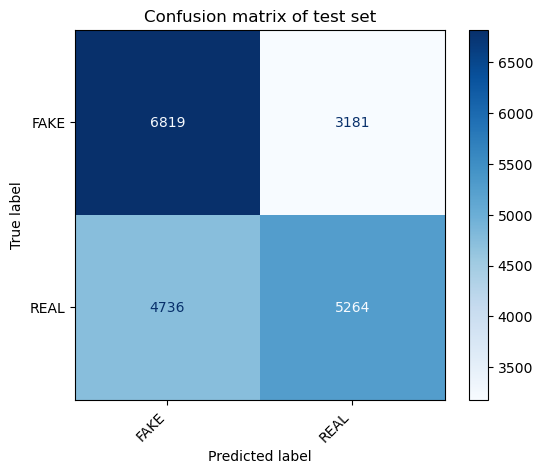

In [31]:
ConfusionMatrixDisplay.from_predictions(test_labels, y_test_pred, display_labels=classes, cmap='Blues')

plt.title('Confusion matrix of test set')
plt.xticks(rotation=45, ha='right')
plt.show()